In [1]:
import pandas as pd
from random import normalvariate, sample, seed
import simpy
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class Shop(object):
    ''' Заведение. У заведения есть несколько касс (num_cashdesks). 
        Время обслуживания (servicetime) с дисперсией (std)
    '''
    def __init__(self, env, name_id, num_cashdesks, servicetime, std):
        self.env = env
        self.id = name_id
        self.cashdesk = simpy.Resource(env, num_cashdesks)
        self.servicetime = servicetime
        self.std = std

    def service(self, visitor):
        yield self.env.timeout(abs(normalvariate(self.servicetime,self.std)))
        visitor.shop.append(self.id)

In [3]:
class Visitor(object):
    ''' Посетитель. 
        Время появление и ухода на улицу (arrives, leaves_street)
        Списки посещенных магазинов, с временем прихода и ухода (shop, enters, leaves)
        История выбора, мест, от посещения которых отказался (нет свободных касс) (choices, deny)
    '''
    def __init__(self, env, i):
        self.env = env
        self.id = i
        self.arrives = 0
        self.enters = []
        self.leaves = []
        self.shop = []
        self.prob = '0001112345'
        self.choices = []
        self.deny = []
        self.leaves_street = 0
        
    def make_choice(self):
        ''' Процесс выбора. 0-4 индексы магазинов, 5 - выход'''
        choice = sample(self.prob,1)
        self.prob = self.prob.replace(choice[0],'5')
        self.choices.append(choice[0])
        return int(choice[0])
    

In [4]:
def visitor_way(env, i, shops):
    ''' Процесс прихода посетителя на улицу, обхода магазинов, и ухода с улицы.'''
    new_visitor = Visitor(env,i)
    new_visitor.arrives = round(env.now,2)
    choice = new_visitor.make_choice()
    
    while choice != 5:
        with shops[choice].cashdesk.request() as request:
            patience = 0
            results = yield request | env.timeout(patience)
            
            if request in results:
                new_visitor.enters.append(round(env.now,2))
                yield env.process(shops[choice].service(new_visitor))
                new_visitor.leaves.append(round(env.now,2))
            else:
                new_visitor.deny.append(shops[choice].id)
        choice = new_visitor.make_choice()
        
    new_visitor.leaves_street = round(env.now,2)
    visitors_list.append(new_visitor)

In [5]:
def setup(env, visitor_interval, visitor_interval_std):
    """ Инициализация магазинов, создание новых посетителей с интервалом
        visitor_interval и дисперсией visitor_interval_std
    """
    shops = []
    shops.append(Shop(env, 'shop1', 3, 5, 2))
    shops.append(Shop(env, 'shop2', 3, 5, 2))
    shops.append(Shop(env, 'kiosk', 1, 3, 2))
    shops.append(Shop(env, 'pharmacy', 2, 5, 2))
    shops.append(Shop(env, 'barbershop', 2, 20, 2))
    i = 0
    
    while True:
        env.process(visitor_way(env, i, shops))
        i += 1
        yield env.timeout(abs(normalvariate(visitor_interval,
                                            visitor_interval_std)))

In [6]:
RANDOM_SEED = 42
DAYS = 30
SIM_TIME = DAYS * 24 * 60
VISITORS_INTERVAL = 5
VISITORS_INTERVAL_STD = 2

In [7]:
# запускаем симуляцию
visitors_list = list()
seed(RANDOM_SEED)
env = simpy.Environment()
env.process(setup(env, VISITORS_INTERVAL, VISITORS_INTERVAL_STD))
env.run(SIM_TIME)

In [8]:
visitors_attrs = [arg for arg in dir(visitors_list[0]) if not arg.startswith('_')]
visitors_attrs

['arrives',
 'choices',
 'deny',
 'enters',
 'env',
 'id',
 'leaves',
 'leaves_street',
 'make_choice',
 'prob',
 'shop']

In [9]:
# параметры для df
attrs_for_df = [ 'arrives',
                 'choices',
                 'deny',
                 'enters',
                 'id',
                 'leaves',
                 'leaves_street',
                 'shop']
data_for_df = [list() for _ in range(len(attrs_for_df))]

In [10]:
# готовим df
for visitor in visitors_list:
    for i, attr in enumerate(attrs_for_df):
        data_for_df[i].append(getattr(visitor,attr))

df = pd.DataFrame(dict(zip(attrs_for_df, data_for_df)))
df.head()

,arrives,choices,deny,enters,id,leaves,leaves_street,shop
0,0.00,"[1, 0, 5]",[],"[0, 3.98]",0,"[3.98, 14.61]",14.61,"[shop2, shop1]"
1,13.84,"[1, 5]",[],[13.84],3,[16.64],16.64,[shop2]
2,5.49,"[0, 1, 5]",[],"[5.49, 8.67]",1,"[8.67, 17.15]",17.15,"[shop1, shop2]"
3,18.19,"[2, 5]",[],[18.19],4,[19.14],19.14,[kiosk]
4,23.03,"[1, 5]",[],[23.03],5,[28.76],28.76,[shop2]


In [11]:
# смотрим на длительность пребывания на улице
df['duration'] = df['leaves_street'] - df['arrives']
df['duration'].describe()

count    8592.000000
mean       11.639960
std         9.956784
min         0.000000
25%         4.690000
50%         8.510000
75%        16.040000
max        47.450000
Name: duration, dtype: float64

In [12]:
TIME_FOR_VIZ = 5

In [13]:
#df.to_csv('data.csv')

In [14]:
attrs_for_dfvis = ['id', 'enters', 'leaves', 'shop']
data_for_dfvis = [list() for _ in range(len(attrs_for_dfvis))]

In [15]:
for i in tqdm_notebook(df.index):
    for j in range(len(df['enters'][i])):
        data_for_dfvis[0].append(df.id[i])
        data_for_dfvis[1].append(df['enters'][i][j])
        data_for_dfvis[2].append(df['leaves'][i][j])
        data_for_dfvis[3].append(df['shop'][i][j])

In [16]:
len(data_for_dfvis[0]), len(data_for_dfvis[1]), len(data_for_dfvis[2]), len(data_for_dfvis[3])

(15465, 15465, 15465, 15465)

In [17]:
dfviz = pd.DataFrame(dict(zip(attrs_for_dfvis, data_for_dfvis)))
dfviz.head()

,id,enters,leaves,shop
0,0,0.00,3.98,shop2
1,0,3.98,14.61,shop1
2,3,13.84,16.64,shop2
3,1,5.49,8.67,shop1
4,1,8.67,17.15,shop2


In [18]:
shop_names = ['shop1','shop2','kiosk','pharmacy','barbershop']
dfviz['before'] = dfviz['enters'] - TIME_FOR_VIZ
dfviz['after'] = dfviz['leaves'] + TIME_FOR_VIZ

In [19]:
for idv in tqdm_notebook(range(dfviz.shape[0])):
    cond = (dfviz['id'] == idv)
    for i in range(dfviz[cond].shape[0]):
        for j in range(dfviz[cond].shape[0]):
            if (dfviz['enters'][cond].iloc[i] <= dfviz['before'][cond].iloc[j]) & (dfviz['leaves'][cond].iloc[i] >= dfviz['before'][cond].iloc[j]):
                dfviz.loc[dfviz[cond].index.values[j], 'before_hist'] = dfviz['shop'][cond].iloc[i]
            if (dfviz['enters'][cond].iloc[i] <= dfviz['after'][cond].iloc[j]) & (dfviz['leaves'][cond].iloc[i] >= dfviz['after'][cond].iloc[j]):
                dfviz.loc[dfviz[cond].index.values[j], 'after_hist'] = dfviz['shop'][cond].iloc[i]          

In [ ]:
for idv in tqdm_notebook(range(dfviz.shape[0])):
    cond = (dfviz['id'] == idv)

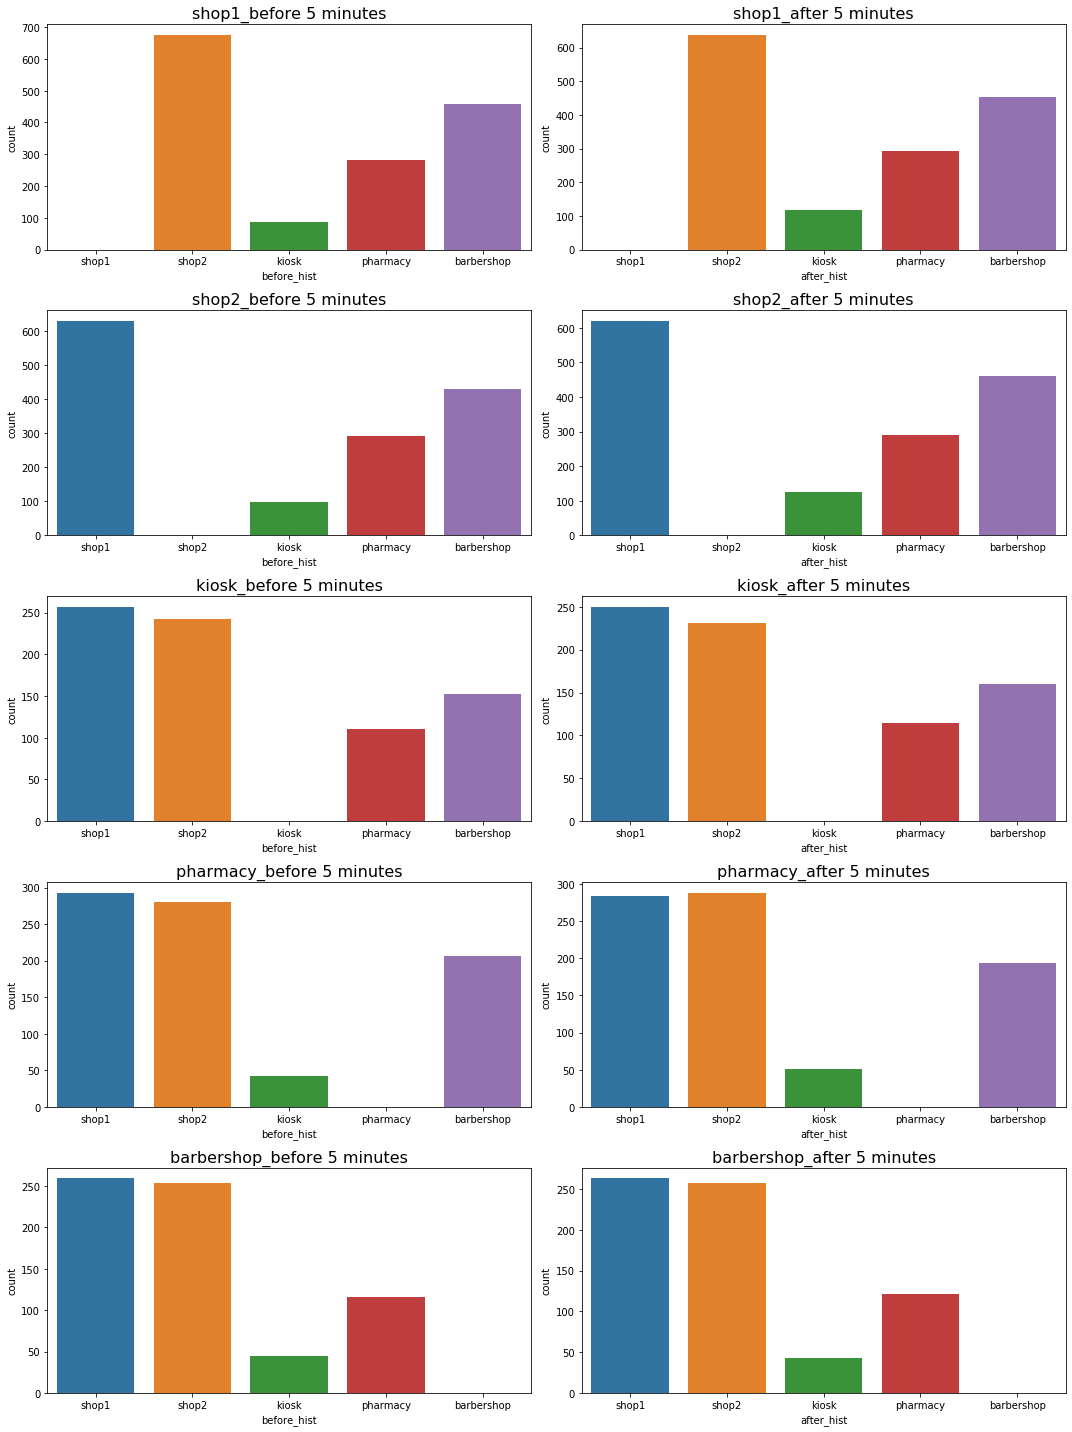

In [20]:
plt.subplots(5, 2,figsize = (15, 20))
for i in range(5):
    plt.subplot(5,2, (2*i+1))
    plt.title (shop_names[i] + "_before " + str(TIME_FOR_VIZ) + ' minutes', fontsize=16)
    sns.countplot(dfviz[dfviz['shop'] == shop_names[i]]['before_hist'], order=shop_names)  
    
    plt.subplot(5,2, (2*i+2))
    plt.title (shop_names[i] + "_after " + str(TIME_FOR_VIZ) + ' minutes', fontsize=16)
    sns.countplot(dfviz[dfviz['shop'] == shop_names[i]]['after_hist'], order=shop_names)
plt.tight_layout()

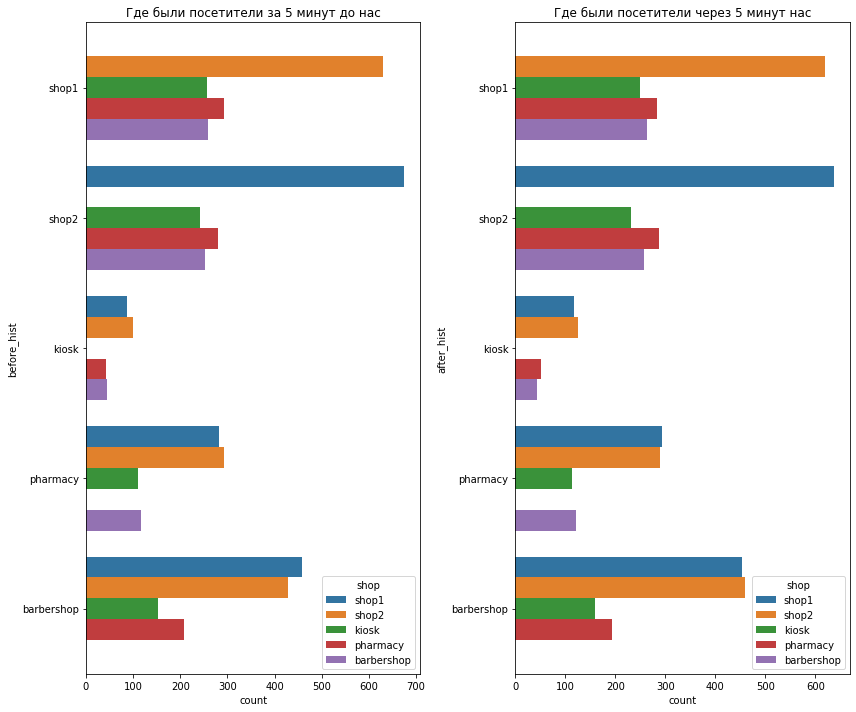

In [21]:
plt.subplots(1, 2,figsize = (12, 10))

plt.subplot(1,2,1)
plt.title ("Где были посетители за " + str(TIME_FOR_VIZ) + ' минут до нас')
sns.countplot(data=dfviz,hue="shop", y='before_hist', order=shop_names, hue_order=shop_names)

plt.subplot(1,2,2)
plt.title ("Где были посетители через " + str(TIME_FOR_VIZ) + ' минут нас')
sns.countplot(data=dfviz,hue="shop", y='after_hist', order=shop_names, hue_order=shop_names)

plt.tight_layout()